<a href="https://colab.research.google.com/github/evan-placenis/Auto-ML/blob/main/Auto_ML_CNN_Modelipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [6]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import pathlib
import numpy as np
import os
import shutil
import tensorflow as tf

##Functions

In [7]:
#Function to load TensorFlow Dataset Food101 - 101 classes of different food
def load_dataset():
  (train_dataset, val_dataset), info = tfds.load(
    "food101",
    split = ['train[:5%]','validation[:5%]'],
    shuffle_files = True,
    as_supervised = True, #returns as (img, label) instead of dict
    with_info = True,
  )
  #print(info)
  print("train_dataset: ", len(train_dataset))
  print("val_dataset: ",len(val_dataset))

  return train_dataset, val_dataset, info

In [16]:
#resize images to [224,224] without normalization because effifientNet normalizes in the layer
def preprocess_img(image,label):
  resized_image = tf.image.resize(image, [224, 224])
  resized_image = tf.expand_dims(resized_image, axis=-1)
  print("image shape: ",  resized_image)
  return tf.cast(resized_image,tf.float32), label

In [17]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

##Data Preperation

In [18]:
train_dataset, val_dataset, info = load_dataset()

train_dataset:  3788
val_dataset:  1262


In [19]:
BATCH_SIZE = 64
#TRATIN
train_dataset = train_dataset.map(preprocess_img, num_parallel_calls = tf.data.experimental.AUTOTUNE).cache().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

#VALIDATION
val_dataset = val_dataset.map(preprocess_img).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

image shape:  Tensor("ExpandDims:0", shape=(224, 224, 3, 1), dtype=float32)
image shape:  Tensor("ExpandDims:0", shape=(224, 224, 3, 1), dtype=float32)


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

#Implement Transfer Learning Model with EfficientNetB0

In [51]:
import tensorflow_hub as hub
from tensorflow.keras import layers

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#input layer
inputs = layers.Input(shape = input_shape, name = "input_layer")

x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) #if its just a layer put on RHS (above are models so they go into it)
outputs = layers.Dense(101, activation = "softmax", name = "output_layer")(x)
model = keras.Model(inputs,outputs)

model.compile(loss="sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_history= model.fit(train_dataset,
                            epochs = 4,
                            steps_per_epoch = len(train_dataset),
                            validation_data = val_dataset,
                            validation_steps = len(val_dataset))

Epoch 1/4
60/60 [==============================] - 32s 424ms/step - loss: 4.0614 - accuracy: 0.1426 - val_loss: 3.2882 - val_accuracy: 0.3368
Epoch 2/4
60/60 [==============================] - 27s 457ms/step - loss: 2.9565 - accuracy: 0.4002 - val_loss: 2.6337 - val_accuracy: 0.4287
Epoch 3/4
60/60 [==============================] - 23s 384ms/step - loss: 2.3832 - accuracy: 0.5034 - val_loss: 2.3108 - val_accuracy: 0.4699
Epoch 4/4
60/60 [==============================] - 24s 405ms/step - loss: 2.0615 - accuracy: 0.5657 - val_loss: 2.1247 - val_accuracy: 0.5016


#Fine Tune Model

In [52]:
initial_epochs = 5
fine_tune_epochs = initial_epochs + 4

model.compile(loss="sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(0.001),
                metrics = ["accuracy"])

model_history_finetune = model.fit(train_dataset,
                                    epochs = fine_tune_epochs,
                                    validation_data = val_dataset,
                                    validation_steps = len(val_dataset),
                                    initial_epoch = model_history.epoch[-1])#start fine tuing from previous epoch


Epoch 4/10
60/60 [==============================] - 33s 418ms/step - loss: 1.8680 - accuracy: 0.5884 - val_loss: 1.9955 - val_accuracy: 0.5182
Epoch 5/10
60/60 [==============================] - 24s 401ms/step - loss: 1.6358 - accuracy: 0.6365 - val_loss: 1.9145 - val_accuracy: 0.5269
Epoch 6/10
60/60 [==============================] - 22s 365ms/step - loss: 1.4951 - accuracy: 0.6661 - val_loss: 1.8569 - val_accuracy: 0.5341
Epoch 7/10
60/60 [==============================] - 21s 353ms/step - loss: 1.3688 - accuracy: 0.6924 - val_loss: 1.8310 - val_accuracy: 0.5396
Epoch 8/10
60/60 [==============================] - 21s 347ms/step - loss: 1.2724 - accuracy: 0.7204 - val_loss: 1.8024 - val_accuracy: 0.5396
Epoch 9/10
60/60 [==============================] - 19s 318ms/step - loss: 1.1820 - accuracy: 0.7381 - val_loss: 1.7921 - val_accuracy: 0.5420
Epoch 10/10
60/60 [==============================] - 19s 321ms/step - loss: 1.1143 - accuracy: 0.7603 - val_loss: 1.7726 - val_accuracy: 0.538

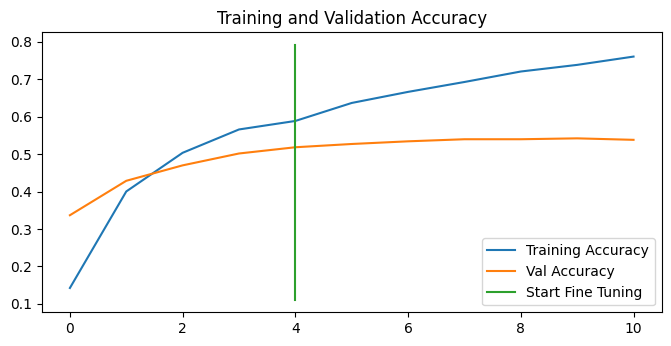

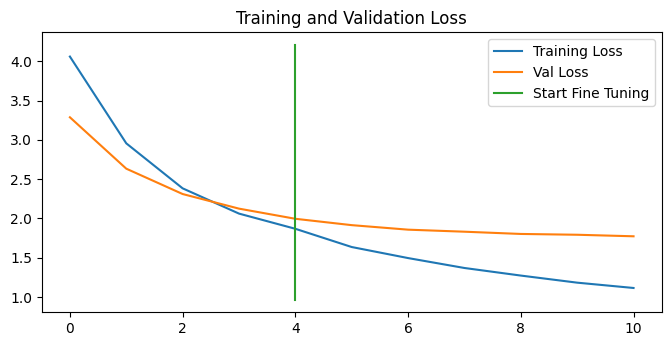

In [54]:
#Update plot loss curves function that have been fit multiple times (before and after fine tuning)
def compare_history(original_history, new_history, initial_epochs = 5):
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  #combine original history

  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  #accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label = "Training Accuracy")
  plt.plot(total_val_acc, label = "Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  #loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label = "Training Loss")
  plt.plot(total_val_loss, label = "Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

compare_history(model_history, model_history_finetune, 5)

## Make Predictions

In [90]:
import random
def predict_on_img(model):
    eval_data, _ = tfds.load(
      "food101",
      split = 'validation[:1%]',
      shuffle_files = True,
      as_supervised = True, #returns as (img, label) instead of dict
      with_info = True,
    )
    ds_list = list(eval_data)
    random_example = random.choice(ds_list)
    img = random_example[0]
    label = random_example[1]

    img_show = tf.cast(img,tf.float32)/255.0

    img_ = tf.cast(img,tf.float32)
    img = tf.image.resize(img, [224, 224])


    img = tf.expand_dims(img, axis=0)
    predictions = model.predict(img)
    predicted_class = predictions.argmax()

    class_name = _.features["label"].int2str(predicted_class)
    print("class Number:", predicted_class, "Predicted class--> ",class_name)
    print("actual class ==>",label.numpy(),"-", _.features["label"].int2str(label.numpy()))

    text_color = 'green' if class_name == _.features["label"].int2str(label.numpy()) else 'red'
    text_message = 'Correct!' if  class_name == _.features["label"].int2str(label.numpy()) else 'Incorrect!'
    plt.text(200, -10, text_message, fontsize=12, color=text_color)
    plt.imshow(img_show)
    plt.show()

1/1 [==============================] - 0s 26ms/step
class Number: 26 Predicted class-->  crab_cakes
actual class ==> 26 - crab_cakes


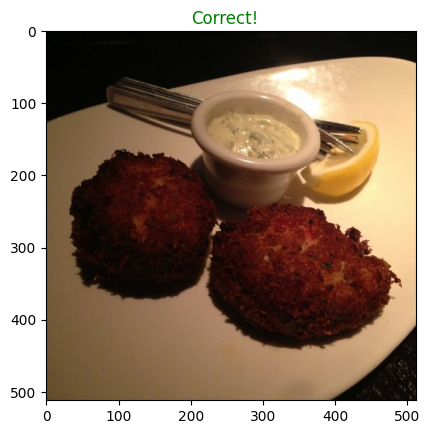

In [93]:
predict_on_img(model)

## Save Model to Local Machine

In [73]:
from google.colab import files

model.save('Auto_ML_CNN.h5')
#download model to files
files.download('Auto_ML_CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load the model

In [74]:
#drag the saved file into the collab directory first!
from tensorflow.keras.models import load_model
save_path = "/content/Auto_ML_CNN.h5"
loaded_model = load_model(save_path)

1/1 [==============================] - 0s 34ms/step
class Number: 91 Predicted class-->  spaghetti_carbonara
actual class ==> 91 - spaghetti_carbonara


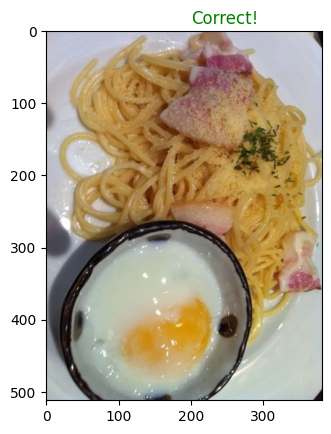

In [97]:
predict_on_img(loaded_model)